### Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from numpy.linalg import qr, norm
import open3d as o3d
import datetime
from utils import Logger, mkdir_p, progress_bar, save_model, save_args, cal_loss
from collections import defaultdict

import sklearn.metrics as metrics
from data import ModelNet40
from torch.optim.lr_scheduler import CosineAnnealingLR
import sklearn.metrics as metrics
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# degree = 10
# d = 3
# num_poly = math.comb(degree + d, d)
# print('num_poly:', num_poly)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# exponents = []
# # Generate all multi-indices with total degree up to 'degree'
# for total_degree in range(degree + 1):
#     for exps in combinations_with_replacement(range(d), total_degree):
#         exp = torch.zeros(d, dtype=int, device=device)
#         for var in exps:
#             exp[var] += 1
#         exponents.append(exp)
# M = len(exponents)
# print('Number of monomials:', M)
# print('Monomials:', exponents[:10])

# exponents = torch.zeros(num_poly, d, dtype=int, device=device)
# i = 0
# for total_degree in range(degree + 1):
#     for exps in combinations_with_replacement(range(d), total_degree):
#         for var in exps:
#             exponents[i, var] += 1
#         i += 1

# print('Monomials:', exponents[:10])
# print(exponents.shape, exponents.dtype, exponents.device)

In [3]:
from itertools import combinations_with_replacement

def generate_exponents(d, degree):
    """
    Generate all multi-indices with total degree up to 'degree' for d-dimensional points.
    
    Parameters:
        d (int): The dimension of the points.
        degree (int): The maximum degree of the monomials.
    
    Returns:
        ndarray: The multi-indices of shape (num_poly, d).
    """
    num_poly = math.comb(degree + d, d)
    exponents = torch.zeros(num_poly, d, dtype=int)
    i = 0
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            for var in exps:
                exponents[i, var] += 1
            i += 1
            
    return exponents

def generate_monomials_sequences_batch(X, exponents):
    """
    Generate monomials given a point cloud and multi-indices.

    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).

    Returns:
        ndarray: Monomial sequences of shape (B, M).
    """
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    M = len(exponents)
    # print(f'Number of monomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    # monomials = torch.ones(B, N, M, device=device)
    # for i, exp in enumerate(exponents):
    #     monomials[:, :, i] = torch.prod(X ** exp, axis=2) # x1^exp1 * x2^exp2 * ... * xd^expd. e.g. x1^2 * x2^3 * x3^1 \in R^3
    monomials = X.unsqueeze(2).repeat(1, 1, M, 1) ** exponents.unsqueeze(0).unsqueeze(0) # (B, N, M, d) ** (1, 1, M, d) -> (B, N, M, d)
    monomials = monomials.prod(dim=-1) # (B, N, M)
    return monomials.sum(dim=1) / N # (B, N, M) -> (B, M)

# def generate_chebyshev_polynomials_sequence_batch_old(X, exponents):
#     """
#     Generate Chebyshev polynomials given a point cloud and multi-indices.

#     Parameters:
#         X (ndarray): An array of shape (B, N, d) representing the d-dimensional point cloud.
#         exponents (ndarray): The multi-indices of shape (M, d).

#     Returns:
#         ndarray: Chebyshev polynomial sequences of shape (B, M).
#     """
#     B, N, d = X.shape
#     device = X.device
#     exponents = exponents.to(device)
#     M = len(exponents)
#     # print(f'Number of Chebyshev polynomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
#     cheby_polynomials = torch.ones(B, N, M, device=device)
#     for i, exp in enumerate(exponents):
#         cheby_polynomials[:, :, i] = torch.prod(torch.cos(exp * torch.acos(X)), axis=2)
    
#     return cheby_polynomials.sum(dim=1) / N # (B, N, M) -> (B, M)

def generate_chebyshev_polynomials_sequence_batch(X, exponents):
    """
    Generate Chebyshev polynomials given a point cloud and multi-indices.

    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the d-dimensional point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).

    Returns:
        ndarray: Chebyshev polynomial sequences of shape (B, M).
    """
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    cheby_polynomials = torch.cos(exponents.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2)) # (B, N, M)
    cheby_polynomials = cheby_polynomials.prod(dim=-1) # (B, N)
    
    return cheby_polynomials.sum(dim=1) / N # (B, N, M) -> (B, M)

def poly_seq_batch(X, exponents, poly_type='monomial'):
    if poly_type == 'monomial':
        return generate_monomials_sequences_batch(X, exponents)
    elif poly_type == 'chebyshev':
        return generate_chebyshev_polynomials_sequence_batch(X, exponents)
    else:
        raise ValueError('Unknown polynomial type')

In [4]:
# exponents = generate_exponents(d, degree)
# print('exponents:', exponents.shape, exponents[:10])

# X = torch.rand(2, 100, 3)
# polys = generate_chebyshev_polynomials_sequence_batch(X, exponents)
# print('polys:', polys.shape, polys[0, :10])

# polys = generate_chebyshev_polynomials_sequence_batch_old(X, exponents)
# print('polys:', polys.shape, polys[0, :10])

# # time the above functions
# import time

# X = torch.rand(2, 100, 3)
# start = time.time()
# polys = generate_chebyshev_polynomials_sequence_batch(X, exponents)
# print('Time:', time.time() - start)

# start = time.time()
# polys = generate_chebyshev_polynomials_sequence_batch_old(X, exponents)
# print('Time:', time.time() - start)

### Use ModelNet40 as our dataset

### A simple Linear classifier

In [5]:
class MLPClaasifier(nn.Module):
    def __init__(self, dim_in, layer_dims, dim_out, dropout=0.5):
        super(MLPClaasifier, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Sequential(
            nn.Linear(dim_in, layer_dims[0]),
            nn.BatchNorm1d(layer_dims[0]),
            nn.ReLU(),
        ))
        for i in range(1, len(layer_dims)):
            self.convs.append(nn.Sequential(
                nn.Linear(layer_dims[i-1], layer_dims[i]),
                nn.BatchNorm1d(layer_dims[i]),
                nn.Dropout(dropout),
                nn.ReLU(),
            ))
        self.convs.append(nn.Linear(layer_dims[-1], dim_out))

    def forward(self, x):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x)
        x = self.convs[-1](x)
        return x
    
x = torch.randn(32, 100) # 32 samples, 100 features
model = MLPClaasifier(100, [128, 64], 40)
y = model(x)
print(y.shape)

torch.Size([32, 40])


### A Residual Classifier

In [6]:
class ResNetCls(nn.Module):
    def __init__(self, dim_in, layer_dims, dim_out, dropout=0.5):
        super(MLPClaasifier, self).__init__()
        self.convs = nn.ModuleList()
        # each block has two conv layers and a skip connection
        for i in range(len(layer_dims)):
            self.convs.append(nn.Sequential(
                nn.Linear(dim_in, layer_dims[i]),
                nn.BatchNorm1d(layer_dims[i]),
                nn.ReLU(),
                nn.Linear(layer_dims[i], layer_dims[i]),
                nn.BatchNorm1d(layer_dims[i]),
                nn.ReLU(),
            ))
            if i == 0:
                self.convs.append(nn.Linear(dim_in, layer_dims[i]))
            else:
                self.convs.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
        self.convs.append(nn.Linear(layer_dims[-1], dim_out))

    def forward(self, x):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x)
        x = self.convs[-1](x)
        return x

In [7]:
class MomentNet(nn.Module):
    def __init__(self, dim_in, dim_out, degree, poly_type='chebyshev', cls_type='mlp', layer_dims=None):
        super(MomentNet, self).__init__()
        self.poly_type = poly_type
        self.exponts = generate_exponents(dim_in, degree)
        self.num_poly = len(self.exponts)
        if cls_type == 'linear':
            self.cls = nn.Linear(self.num_poly, dim_out)
        elif cls_type == 'mlp':
            self.cls = MLPClaasifier(self.num_poly, layer_dims, dim_out)
        
    def forward(self, x):
        x = poly_seq_batch(x, self.exponts, self.poly_type)
        x = self.cls(x)
        return x
    
x = torch.randn(32, 2048, 3) # 32 samples, 2048 points, 3 features
model = MomentNet(3, 40, 2, poly_type='monomial', layer_dims=[128, 64], cls_type='mlp')
y = model(x)
print(y.shape)

torch.Size([32, 40])


In [8]:
def train(net, trainloader, optimizer, criterion, epoch, num_epochs, device, verbose=True):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_pred = []
    train_true = []
    time_cost = datetime.datetime.now()
    if verbose:
        pbar = tqdm(enumerate(trainloader), total=len(trainloader))
    else:
        pbar = enumerate(trainloader)
    for batch_idx, (data, label) in pbar:
        data, label = data.to(device), label.to(device).squeeze()
        optimizer.zero_grad()
        logits = net(data)
        loss = criterion(logits, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
        preds = logits.max(dim=1)[1]

        train_true.append(label.cpu().numpy())
        train_pred.append(preds.detach().cpu().numpy())

        total += label.size(0)
        correct += preds.eq(label).sum().item()

        if verbose:
            pbar.set_description(f'({epoch:3d}/{num_epochs:3d}) Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100. * correct / total:.3f}% ({correct}/{total})')
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    time_cost = int((datetime.datetime.now() - time_cost).total_seconds())
    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    return {
        "loss": float("%.3f" % (train_loss / (batch_idx + 1))),
        "acc": float("%.3f" % (100. * metrics.accuracy_score(train_true, train_pred))),
        "acc_avg": float("%.3f" % (100. * metrics.balanced_accuracy_score(train_true, train_pred))),
        "time": time_cost
    }


def validate(net, testloader, criterion, epoch, num_epochs, device, verbose=True):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_true = []
    test_pred = []
    time_cost = datetime.datetime.now()
    with torch.no_grad():
        if verbose:
            pbar = tqdm(enumerate(testloader), total=len(testloader))
        else:
            pbar = enumerate(testloader)
        for batch_idx, (data, label) in pbar:
            data, label = data.to(device), label.to(device).squeeze()
            logits = net(data)
            loss = criterion(logits, label)
            test_loss += loss.item()
            preds = logits.max(dim=1)[1]
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
            total += label.size(0)
            correct += preds.eq(label).sum().item()
            if verbose:
                pbar.set_description(f'({epoch:3d}/{num_epochs:3d}) Loss: {test_loss / (batch_idx + 1):.3f} | Acc: {100. * correct / total:.3f}% ({correct}/{total})')
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    time_cost = int((datetime.datetime.now() - time_cost).total_seconds())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    return {
        "loss": float("%.3f" % (test_loss / (batch_idx + 1))),
        "acc": float("%.3f" % (100. * metrics.accuracy_score(test_true, test_pred))),
        "acc_avg": float("%.3f" % (100. * metrics.balanced_accuracy_score(test_true, test_pred))),
        "time": time_cost
    }

In [9]:
# Training (Taken from PointMLP-PyTorch)
def run_experiment(num_epochs = 50, # Number of epochs
                   max_lr = 0.1, # Maximum learning rate
                   min_lr = 0.001, # Minimum learning rate
                   degree = 10, # Degree of the polynomials
                   poly_type = 'chebyshev', # Type of polynomials
                   cls_type = 'mlp', # Type of classifier ['mlp', 'linear']                    
                   layer_dims = [512, 256, 128], # Layer dimensions for the classifier (MLP)
                   num_points = 1024,
                   batch_size = 32,
                   verbose = False
                   ): 

    train_loader = DataLoader(ModelNet40(partition='train', 
                                            num_points=num_points,
                                            aug=True), 
                                num_workers=8,
                                batch_size=batch_size, 
                                shuffle=True, 
                                drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', 
                                            num_points=num_points,
                                            aug=False), 
                                num_workers=8,
                                batch_size=batch_size // 2, 
                                shuffle=False, 
                                drop_last=False)
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    best_test_acc = 0.  # best test accuracy
    best_train_acc = 0.
    best_test_acc_avg = 0.
    best_train_acc_avg = 0.
    best_test_loss = float("inf")
    best_train_loss = float("inf")
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    # Model
    net = MomentNet(3, 40, degree = degree, poly_type = poly_type, cls_type=cls_type, layer_dims=layer_dims).to(device)

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=max_lr, momentum=0.9, weight_decay=0)
    scheduler = CosineAnnealingLR(optimizer, num_epochs, eta_min=min_lr, last_epoch=start_epoch - 1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(start_epoch, num_epochs):
        train_out = train(net, train_loader, optimizer, criterion, epoch, num_epochs, device, verbose)  # {"loss", "acc", "acc_avg", "time"}
        test_out = validate(net, test_loader, criterion, epoch, num_epochs, device, verbose)
        scheduler.step()
        if test_out["acc"] > best_test_acc:
            best_test_acc = test_out["acc"]
            is_best = True
        else:
            is_best = False

        best_test_acc = test_out["acc"] if (test_out["acc"] > best_test_acc) else best_test_acc
        best_train_acc = train_out["acc"] if (train_out["acc"] > best_train_acc) else best_train_acc
        best_test_acc_avg = test_out["acc_avg"] if (test_out["acc_avg"] > best_test_acc_avg) else best_test_acc_avg
        best_train_acc_avg = train_out["acc_avg"] if (train_out["acc_avg"] > best_train_acc_avg) else best_train_acc_avg
        best_test_loss = test_out["loss"] if (test_out["loss"] < best_test_loss) else best_test_loss
        best_train_loss = train_out["loss"] if (train_out["loss"] < best_train_loss) else best_train_loss

        if verbose:
            print(
            f"Training loss:{train_out['loss']} acc_avg:{train_out['acc_avg']}% acc:{train_out['acc']}% time:{train_out['time']}s")
            print(
            f"Testing loss:{test_out['loss']} acc_avg:{test_out['acc_avg']}% "
            f"acc:{test_out['acc']}% time:{test_out['time']}s [best test acc: {best_test_acc}%]")

    return {
        "best_test_acc": best_test_acc,
        "best_train_acc": best_train_acc,
        "best_test_acc_avg": best_test_acc_avg,
        "best_train_acc_avg": best_train_acc_avg,
        "best_test_loss": best_test_loss,
        "best_train_loss": best_train_loss
    }
    

In [10]:
# run experiments to see the effect of polynomial degrees
degrees = [2, 4, 6, 8, 10, 12, 14, 16]
results = defaultdict(list)
for degree in degrees:
    print(f"Running experiment for degree {degree}")
    result = run_experiment(num_epochs = 50, degree = degree)
    results['degree'].append(degree)
    for key, value in result.items():
        results[key].append(value)
        
    print(f"Results for degree {degree}: {result}")

Running experiment for degree 2
Results for degree 2: {'best_test_acc': 60.413, 'best_train_acc': 59.507, 'best_test_acc_avg': 49.215, 'best_train_acc_avg': 44.353, 'best_test_loss': 1.237, 'best_train_loss': 1.321}
Running experiment for degree 4
Results for degree 4: {'best_test_acc': 78.444, 'best_train_acc': 74.634, 'best_test_acc_avg': 69.831, 'best_train_acc_avg': 63.909, 'best_test_loss': 0.697, 'best_train_loss': 0.827}
Running experiment for degree 6
Results for degree 6: {'best_test_acc': 82.577, 'best_train_acc': 79.876, 'best_test_acc_avg': 74.914, 'best_train_acc_avg': 70.804, 'best_test_loss': 0.568, 'best_train_loss': 0.655}
Running experiment for degree 8
Results for degree 8: {'best_test_acc': 84.562, 'best_train_acc': 83.662, 'best_test_acc_avg': 76.98, 'best_train_acc_avg': 76.177, 'best_test_loss': 0.535, 'best_train_loss': 0.533}
Running experiment for degree 10
Results for degree 10: {'best_test_acc': 85.494, 'best_train_acc': 85.943, 'best_test_acc_avg': 79.01, '

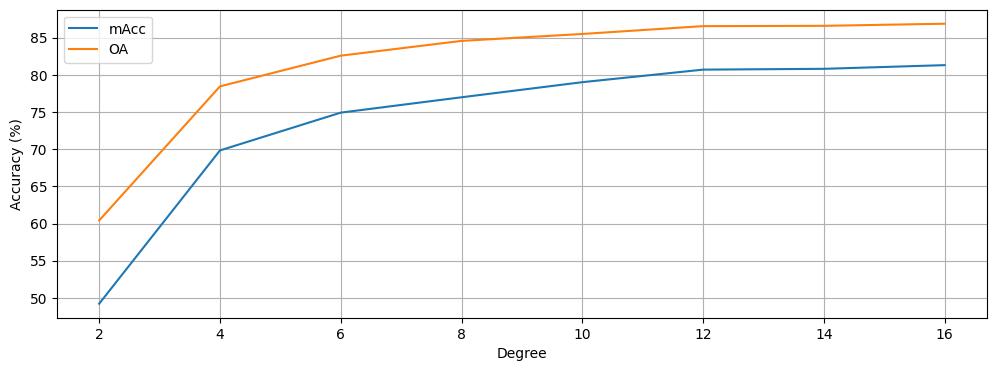

In [12]:
# plot the results
plt.figure(figsize=(12, 4))
plt.plot(results['degree'], results['best_test_acc_avg'], label='mAcc')
plt.plot(results['degree'], results['best_test_acc'], label='OA')
plt.xlabel('Degree')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()
